README: this file combine two modeling methods for time features (ARIMA + linear regression), and stack them together
- reformat price data by property_id, and predict by prop_id

In [35]:
import os
os.chdir('/Users/liyuan/desktop/SI699/codes')
import pandas as pd
import numpy as np
import time

from ts_modeling_v2 import TsModeling
from reformat_data_by_day import Reformat_data
from time_feature_modeling import TimeFeatureModeling
from help import sample_data, get_rmse, get_predictions,extract_time_features

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [36]:
# reformat functions into one big function -> input: prop_id, output: predictions 
class PredictByProp(object):
    def __init__(self,prop_id):
        self.prop_id = prop_id
        self.prop_data = pd.Series()
        self.daily_price = pd.Series()
        
    def get_prop_data(self,input_data_path):
        # prepare price data by property
        tsm = TsModeling()
        rf = Reformat_data()
        self.data = rf.load_data(input_data_path)
        self.prop_data_list = rf.get_data_by_prop()

        # sort prop_id based on the number of records in descending order
        sorted_props = sorted(prop_data_list, key = lambda x: len(prop_data_list[x]), reverse = True)
        print('Properties with the largest number of records:', sorted_props[:10])

        self.prop_data = prop_data_list[self.prop_id]
        self.prop_data = tsm.process_data_by_prop(self.prop_data)
        self.daily_price = self.prop_data[['price_usd']].resample('D').median()
        self.daily_price.head()
        return self.daily_price

    def fit_ARIMA(self, p=2,d=1,q=1):
        tsm.get_auto_correlation(self.daily_price)
        train, val, test = tsm.split_data(self.daily_price) # split X
        print('plot for ARIMA model ...')
        val_predictions, test_predictions = tsm.fit_ARIMA_model(self.daily_price.dropna(), p,d,q)
        return val_predictions, test_predictions

    def fit_regression(self):
        # fit regression model on daily_price
        daily_price = extract_time_features(self.daily_price)
        print(self.daily_price.head())
        regression_y_pred_train, regression_y_pred_val, regression_y_pred_test = tsm.fit_regression_model(daily_price.dropna())
        return regression_y_pred_train, regression_y_pred_val, regression_y_pred_test

    def model_stacking(self, model):
        ''' model stacking for second-layer modeling'''
        y_pred_train, y_pred_test = tsm.second_layer_modeling(model)
        return y_pred_train, y_pred_test


Properties with the largest number of records: [116942, 49656, 38419, 124342, 60846, 70177, 104517, 134154, 78500, 68420]


/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prop_data['date_time'] = pd.to_datetime(prop_data.date_time)
/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:76: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  autocorrelation_plot(data)


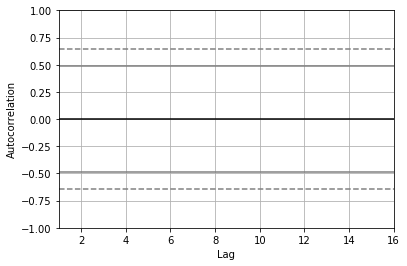

training size: 10
validation size: 2
test size: 3
plot for ARIMA model ...
training size: 10
validation size: 2
test size: 3


/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

RMSE: 45.577


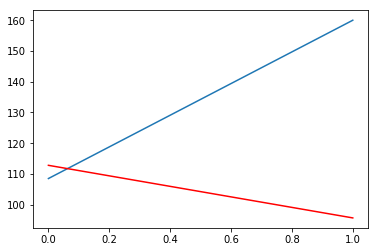

RMSE: 15.103


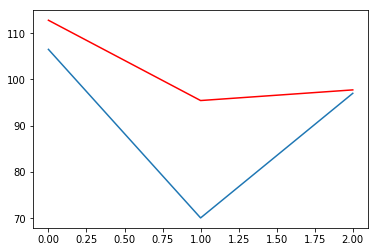

            price_usd
date_time            
2012-11-01      85.00
2012-11-02      90.00
2012-11-03        NaN
2012-11-04      74.46
2012-11-05      91.00
price data len: 15
15


/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['day'] = price_data['date_time'].apply(lambda x: x.day)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['week'] = price_data['date_time'].apply(lambda x: x.week)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

variance of data: 714
training size: 10
validation size: 2
test size: 3
training RMSE: 20.587922990462747
valiation RMSE: 39.38501120293375
test RMSE: 30.17889158535432
(2, 1)
(3, 1)
(2, 1)
(3, 1)
y_train shape: (2, 1)
y_test shape: (3, 1)
train rmse: 40
test rmse: 19
--- takes 36.11835598945618 seconds to finish ---


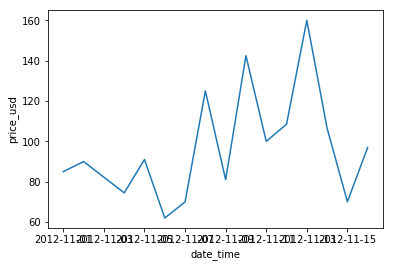

In [38]:
start_time = time.time()
# enter a prop_id
prop_p = PredictByProp(116942)
daily_price = prop_p.get_prop_data('../res/sampled_data_100000.csv')
# daily_price = prop_p.get_prop_data('../expedia_data/all_data.csv')
prop_p.fit_ARIMA(2,0,0)
prop_p.fit_regression()
# use XGBoost (has the best performance)
y_pred_train, y_pred_test = prop_p.model_stacking( model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 3, reg_alpha = 20, n_estimators = 25)  )
print('--- takes %s seconds to finish ---'%str(time.time() - start_time))